In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
from func_get import *
from func_signal import *
from func_backtest import *

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/ftx_read_keys.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'messi'

In [7]:
start_date = dt.datetime(2021, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '2h',
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '2h': {
                'tma': {
                    'check': [check_signal_side_change],
                    'look_back': 1,
                    'windows': 50,
                    'revert': False
                }
            }
        },
        'close': {
            '2h': {
                'tma': {
                    'check': [check_signal_side],
                    'look_back': 1,
                    'windows': 50,
                    'revert': False
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'price_percent': None,
        'signal': None
    },
    'action_percent': 1,
    'leverage': 1,
    'taker_fee': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/593
base: timeframe 1/1 symbol 1/1 date 2/593
base: timeframe 1/1 symbol 1/1 date 3/593
base: timeframe 1/1 symbol 1/1 date 4/593
base: timeframe 1/1 symbol 1/1 date 5/593
base: timeframe 1/1 symbol 1/1 date 6/593
base: timeframe 1/1 symbol 1/1 date 7/593
base: timeframe 1/1 symbol 1/1 date 8/593
base: timeframe 1/1 symbol 1/1 date 9/593
base: timeframe 1/1 symbol 1/1 date 10/593
base: timeframe 1/1 symbol 1/1 date 11/593
base: timeframe 1/1 symbol 1/1 date 12/593
base: timeframe 1/1 symbol 1/1 date 13/593
base: timeframe 1/1 symbol 1/1 date 14/593
base: timeframe 1/1 symbol 1/1 date 15/593
base: timeframe 1/1 symbol 1/1 date 16/593
base: timeframe 1/1 symbol 1/1 date 17/593
base: timeframe 1/1 symbol 1/1 date 18/593
base: timeframe 1/1 symbol 1/1 date 19/593
base: timeframe 1/1 symbol 1/1 date 20/593
base: timeframe 1/1 symbol 1/1 date 21/593
base: timeframe 1/1 symbol 1/1 date 22/593
base: timeframe 1/1 symbol 1/1 date 23/593
base: timeframe 1/1 

base: timeframe 1/1 symbol 1/1 date 192/593
base: timeframe 1/1 symbol 1/1 date 193/593
base: timeframe 1/1 symbol 1/1 date 194/593
base: timeframe 1/1 symbol 1/1 date 195/593
base: timeframe 1/1 symbol 1/1 date 196/593
base: timeframe 1/1 symbol 1/1 date 197/593
base: timeframe 1/1 symbol 1/1 date 198/593
base: timeframe 1/1 symbol 1/1 date 199/593
base: timeframe 1/1 symbol 1/1 date 200/593
base: timeframe 1/1 symbol 1/1 date 201/593
base: timeframe 1/1 symbol 1/1 date 202/593
base: timeframe 1/1 symbol 1/1 date 203/593
base: timeframe 1/1 symbol 1/1 date 204/593
base: timeframe 1/1 symbol 1/1 date 205/593
base: timeframe 1/1 symbol 1/1 date 206/593
base: timeframe 1/1 symbol 1/1 date 207/593
base: timeframe 1/1 symbol 1/1 date 208/593
base: timeframe 1/1 symbol 1/1 date 209/593
base: timeframe 1/1 symbol 1/1 date 210/593
base: timeframe 1/1 symbol 1/1 date 211/593
base: timeframe 1/1 symbol 1/1 date 212/593
base: timeframe 1/1 symbol 1/1 date 213/593
base: timeframe 1/1 symbol 1/1 d

base: timeframe 1/1 symbol 1/1 date 379/593
base: timeframe 1/1 symbol 1/1 date 380/593
base: timeframe 1/1 symbol 1/1 date 381/593
base: timeframe 1/1 symbol 1/1 date 382/593
base: timeframe 1/1 symbol 1/1 date 383/593
base: timeframe 1/1 symbol 1/1 date 384/593
base: timeframe 1/1 symbol 1/1 date 385/593
base: timeframe 1/1 symbol 1/1 date 386/593
base: timeframe 1/1 symbol 1/1 date 387/593
base: timeframe 1/1 symbol 1/1 date 388/593
base: timeframe 1/1 symbol 1/1 date 389/593
base: timeframe 1/1 symbol 1/1 date 390/593
base: timeframe 1/1 symbol 1/1 date 391/593
base: timeframe 1/1 symbol 1/1 date 392/593
base: timeframe 1/1 symbol 1/1 date 393/593
base: timeframe 1/1 symbol 1/1 date 394/593
base: timeframe 1/1 symbol 1/1 date 395/593
base: timeframe 1/1 symbol 1/1 date 396/593
base: timeframe 1/1 symbol 1/1 date 397/593
base: timeframe 1/1 symbol 1/1 date 398/593
base: timeframe 1/1 symbol 1/1 date 399/593
base: timeframe 1/1 symbol 1/1 date 400/593
base: timeframe 1/1 symbol 1/1 d

base: timeframe 1/1 symbol 1/1 date 566/593
base: timeframe 1/1 symbol 1/1 date 567/593
base: timeframe 1/1 symbol 1/1 date 568/593
base: timeframe 1/1 symbol 1/1 date 569/593
base: timeframe 1/1 symbol 1/1 date 570/593
base: timeframe 1/1 symbol 1/1 date 571/593
base: timeframe 1/1 symbol 1/1 date 572/593
base: timeframe 1/1 symbol 1/1 date 573/593
base: timeframe 1/1 symbol 1/1 date 574/593
base: timeframe 1/1 symbol 1/1 date 575/593
base: timeframe 1/1 symbol 1/1 date 576/593
base: timeframe 1/1 symbol 1/1 date 577/593
base: timeframe 1/1 symbol 1/1 date 578/593
base: timeframe 1/1 symbol 1/1 date 579/593
base: timeframe 1/1 symbol 1/1 date 580/593
base: timeframe 1/1 symbol 1/1 date 581/593
base: timeframe 1/1 symbol 1/1 date 582/593
base: timeframe 1/1 symbol 1/1 date 583/593
base: timeframe 1/1 symbol 1/1 date 584/593
base: timeframe 1/1 symbol 1/1 date 585/593
base: timeframe 1/1 symbol 1/1 date 586/593
base: timeframe 1/1 symbol 1/1 date 587/593
base: timeframe 1/1 symbol 1/1 d

### Add signal

In [10]:
ohlcv_df_dict = add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add tma to ETH-PERP 2h


### Back test

In [11]:
action_time_list = gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / config_params['action_percent'])

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    
    budget, position_dict, transaction_dict = update_close_position(symbol, side, close_price, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2021-01-01 03:00:00: progress 1/5112
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 05:00:00: progress 2/5112
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 07:00:00: progress 3/5112
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 09:00:00: progress 4/5112
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 11:00:00: progress 5/5112
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 13:00:00: progress 6/5112
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 15:00:00: progress 7/5112
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 17:00:00: progress 8/5112
  ETH-PERP
     base ETH-PERP check_signal_side_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-16 13:00:00: progress 186/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-16 15:00:00: progress 187/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-16 17:00:00: progress 188/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-16 19:00:00: progress 189/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-16 21:00:00: progress 190/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-16 23:00:00: progress 191/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-17 01:00:00: progress 192/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-17 03:00:00: progress 193/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy

  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-22 15:00:00: progress 259/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-22 17:00:00: progress 260/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-22 19:00:00: progress 261/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-22 21:00:00: progress 262/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-22 23:00:00: progress 263/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-23 01:00:00: progress 264/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-23 03:00:00: progress 265/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-23 05:00:00: progress 266/5112
  ETH-PERP
     base ETH-PERP check_sign

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-01 19:00:00: progress 381/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-01 21:00:00: progress 382/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-01 23:00:00: progress 383/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-02 01:00:00: progress 384/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-02 03:00:00: progress 385/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-02 05:00:00: progress 386/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-02 07:00:00: progress 387/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 1377.1
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 07:00:00: progress 483/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 09:00:00: progress 484/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 11:00:00: progress 485/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 13:00:00: progress 486/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 15:00:00: progress 487/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 17:00:00: progress 488/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 19:00:00: progress 489/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-10 21:00:00: progress 490/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-19 21:00:00: progress 598/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-19 23:00:00: progress 599/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-20 01:00:00: progress 600/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-20 03:00:00: progress 601/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-20 05:00:00: progress 602/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-20 07:00:00: progress 603/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-20 09:00:00: progress 604/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-20 11:00:00: progress 605/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 05:00:00: progress 746/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 07:00:00: progress 747/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 09:00:00: progress 748/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 11:00:00: progress 749/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 13:00:00: progress 750/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 15:00:00: progress 751/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 17:00:00: progress 752/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-04 19:00:00: progress 753/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 07:00:00: progress 819/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 09:00:00: progress 820/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 11:00:00: progress 821/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 13:00:00: progress 822/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 15:00:00: progress 823/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 17:00:00: progress 824/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 19:00:00: progress 825/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-10 21:00:00: progress 826/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-19 03:00:00: progress 925/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 1767.2
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.06669330775054327
     price: 1767.2
     tp: 0
     sl: inf
Time 2021-03-19 05:00:00: progress 926/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-19 07:00:00: progress 927/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-19 09:00:00: progress 928/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-19 11:00:00: progress 929/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-19 13:00:00: progress 930/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 1803.8
  ETH-PERP
     base ETH-PERP check_signa

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-25 21:00:00: progress 1006/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-25 23:00:00: progress 1007/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-26 01:00:00: progress 1008/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-26 03:00:00: progress 1009/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-26 05:00:00: progress 1010/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-26 07:00:00: progress 1011/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-26 09:00:00: progress 1012/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-26 11:00:00: progress 1013/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 03:00:00: progress 1105/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 05:00:00: progress 1106/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 07:00:00: progress 1107/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 09:00:00: progress 1108/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 11:00:00: progress 1109/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 13:00:00: progress 1110/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 15:00:00: progress 1111/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-03 17:00:00: progress 1112/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-08 13:00:00: progress 1170/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-08 15:00:00: progress 1171/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-08 17:00:00: progress 1172/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-08 19:00:00: progress 1173/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-08 21:00:00: progress 1174/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-08 23:00:00: progress 1175/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 01:00:00: progress 1176/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 03:00:00: progress 1177/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 05:00:00: progress 1274/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 07:00:00: progress 1275/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 09:00:00: progress 1276/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 11:00:00: progress 1277/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 13:00:00: progress 1278/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 15:00:00: progress 1279/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 17:00:00: progress 1280/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-17 19:00:00: progress 1281/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-24 13:00:00: progress 1362/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-24 15:00:00: progress 1363/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-24 17:00:00: progress 1364/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-24 19:00:00: progress 1365/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-24 21:00:00: progress 1366/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-24 23:00:00: progress 1367/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-25 01:00:00: progress 1368/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-25 03:00:00: progress 1369/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-02 21:00:00: progress 1462/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-02 23:00:00: progress 1463/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-03 01:00:00: progress 1464/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-03 03:00:00: progress 1465/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-03 05:00:00: progress 1466/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-03 07:00:00: progress 1467/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-03 09:00:00: progress 1468/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-03 11:00:00: progress 1469/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 03:00:00: progress 1537/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 05:00:00: progress 1538/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 07:00:00: progress 1539/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 09:00:00: progress 1540/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 11:00:00: progress 1541/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 13:00:00: progress 1542/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 15:00:00: progress 1543/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-05-09 17:00:00: progress 1544/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 05:00:00: progress 1622/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 07:00:00: progress 1623/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 09:00:00: progress 1624/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 11:00:00: progress 1625/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 13:00:00: progress 1626/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 15:00:00: progress 1627/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 17:00:00: progress 1628/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-16 19:00:00: progress 1629/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 09:00:00: progress 1696/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 11:00:00: progress 1697/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 13:00:00: progress 1698/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 15:00:00: progress 1699/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 17:00:00: progress 1700/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 19:00:00: progress 1701/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 21:00:00: progress 1702/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-22 23:00:00: progress 1703/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-30 17:00:00: progress 1796/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-30 19:00:00: progress 1797/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-30 21:00:00: progress 1798/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-30 23:00:00: progress 1799/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-31 01:00:00: progress 1800/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-31 03:00:00: progress 1801/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-31 05:00:00: progress 1802/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-31 07:00:00: progress 1803/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.13419119609222538
     price: 2691.5
     tp: 0
     sl: inf
Time 2021-06-05 09:00:00: progress 1864/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 2761.1
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.12724048871577887
     price: 2761.1
     tp: inf
     sl: 0
Time 2021-06-05 11:00:00: progress 1865/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-05 13:00:00: progress 1866/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-05 15:00:00: progress 1867/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-05 17:00:00: progress 1868/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 2706.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.1270605384079

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-14 13:00:00: progress 1974/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-14 15:00:00: progress 1975/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-14 17:00:00: progress 1976/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-14 19:00:00: progress 1977/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-14 21:00:00: progress 1978/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-14 23:00:00: progress 1979/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-15 01:00:00: progress 1980/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-15 03:00:00: progress 1981/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-21 13:00:00: progress 2058/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-21 15:00:00: progress 2059/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-21 17:00:00: progress 2060/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-21 19:00:00: progress 2061/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-21 21:00:00: progress 2062/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-21 23:00:00: progress 2063/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-22 01:00:00: progress 2064/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-22 03:00:00: progress 2065/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-29 11:00:00: progress 2153/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-29 13:00:00: progress 2154/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-29 15:00:00: progress 2155/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-29 17:00:00: progress 2156/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-29 19:00:00: progress 2157/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-29 21:00:00: progress 2158/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-29 23:00:00: progress 2159/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-30 01:00:00: progress 2160/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-11 17:00:00: progress 2300/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-11 19:00:00: progress 2301/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-11 21:00:00: progress 2302/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-11 23:00:00: progress 2303/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 2145.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.18862271844555328
     price: 2145.0
     tp: inf
     sl: 0
Time 2021-07-12 01:00:00: progress 2304/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-12 03:00:00: progress 2305/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-12 05:00:00: progress 2306/5112
  ETH-PERP

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-18 03:00:00: progress 2377/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-18 05:00:00: progress 2378/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-18 07:00:00: progress 2379/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-18 09:00:00: progress 2380/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 1978.2
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.21139282245702956
     price: 1978.2
     tp: inf
     sl: 0
Time 2021-07-18 11:00:00: progress 2381/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-18 13:00:00: progress 2382/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-18 15:00:00: progress 2383/5112
  ETH-PERP

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-25 21:00:00: progress 2470/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-25 23:00:00: progress 2471/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-26 01:00:00: progress 2472/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-26 03:00:00: progress 2473/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-26 05:00:00: progress 2474/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-26 07:00:00: progress 2475/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-26 09:00:00: progress 2476/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-26 11:00:00: progress 2477/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-31 11:00:00: progress 2537/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-31 13:00:00: progress 2538/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-31 15:00:00: progress 2539/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-31 17:00:00: progress 2540/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-31 19:00:00: progress 2541/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-31 21:00:00: progress 2542/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-07-31 23:00:00: progress 2543/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-01 01:00:00: progress 2544/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.17530667940872457
     price: 2949.6
     tp: inf
     sl: 0
Time 2021-08-09 13:00:00: progress 2646/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 2937.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.17506072360031286
     price: 2937.0
     tp: 0
     sl: inf
Time 2021-08-09 15:00:00: progress 2647/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-09 17:00:00: progress 2648/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 3041.4
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.16280147220006103
     price: 3041.4
     tp: inf
     sl: 0
Time 2021-08-09 19:00:00: progress 2649/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-09 21:00:00: progress 2650/5112
  ETH-PERP
     base ETH-PER

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-20 23:00:00: progress 2783/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-21 01:00:00: progress 2784/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-21 03:00:00: progress 2785/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-21 05:00:00: progress 2786/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-21 07:00:00: progress 2787/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-21 09:00:00: progress 2788/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-21 11:00:00: progress 2789/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-08-21 13:00:00: progress 2790/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-26 23:00:00: progress 2855/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-27 01:00:00: progress 2856/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-27 03:00:00: progress 2857/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-27 05:00:00: progress 2858/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-27 07:00:00: progress 2859/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-27 09:00:00: progress 2860/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-27 11:00:00: progress 2861/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-27 13:00:00: progress 2862/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-03 15:00:00: progress 2947/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-03 17:00:00: progress 2948/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-03 19:00:00: progress 2949/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-03 21:00:00: progress 2950/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-03 23:00:00: progress 2951/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-04 01:00:00: progress 2952/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-04 03:00:00: progress 2953/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-04 05:00:00: progress 2954/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 07:00:00: progress 3015/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 09:00:00: progress 3016/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 11:00:00: progress 3017/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 13:00:00: progress 3018/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 15:00:00: progress 3019/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 17:00:00: progress 3020/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 19:00:00: progress 3021/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-09 21:00:00: progress 3022/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-15 17:00:00: progress 3092/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-15 19:00:00: progress 3093/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-15 21:00:00: progress 3094/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-15 23:00:00: progress 3095/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-16 01:00:00: progress 3096/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-16 03:00:00: progress 3097/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-16 05:00:00: progress 3098/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-16 07:00:00: progress 3099/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-22 13:00:00: progress 3174/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-22 15:00:00: progress 3175/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-22 17:00:00: progress 3176/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-22 19:00:00: progress 3177/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-22 21:00:00: progress 3178/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-22 23:00:00: progress 3179/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-23 01:00:00: progress 3180/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-23 03:00:00: progress 3181/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-30 21:00:00: progress 3274/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-30 23:00:00: progress 3275/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-01 01:00:00: progress 3276/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-01 03:00:00: progress 3277/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-01 05:00:00: progress 3278/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-01 07:00:00: progress 3279/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-01 09:00:00: progress 3280/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-01 11:00:00: progress 3281/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-06 11:00:00: progress 3341/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-06 13:00:00: progress 3342/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-06 15:00:00: progress 3343/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-06 17:00:00: progress 3344/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 3364.3
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.16210644355684456
     price: 3364.3
     tp: 0
     sl: inf
Time 2021-10-06 19:00:00: progress 3345/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-06 21:00:00: progress 3346/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 3583.3
  ETH-PERP
     base ETH-PERP check_si

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-12 23:00:00: progress 3419/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-13 01:00:00: progress 3420/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-13 03:00:00: progress 3421/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-13 05:00:00: progress 3422/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-13 07:00:00: progress 3423/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-13 09:00:00: progress 3424/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-13 11:00:00: progress 3425/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-13 13:00:00: progress 3426/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 03:00:00: progress 3493/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 05:00:00: progress 3494/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 07:00:00: progress 3495/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 09:00:00: progress 3496/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 11:00:00: progress 3497/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 13:00:00: progress 3498/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 15:00:00: progress 3499/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-19 17:00:00: progress 3500/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-26 23:00:00: progress 3587/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-27 01:00:00: progress 3588/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-27 03:00:00: progress 3589/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-27 05:00:00: progress 3590/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-27 07:00:00: progress 3591/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-27 09:00:00: progress 3592/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-27 11:00:00: progress 3593/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-10-27 13:00:00: progress 3594/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 03:00:00: progress 3733/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 05:00:00: progress 3734/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 07:00:00: progress 3735/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 09:00:00: progress 3736/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 11:00:00: progress 3737/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 13:00:00: progress 3738/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 15:00:00: progress 3739/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-08 17:00:00: progress 3740/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-13 23:00:00: progress 3803/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-14 01:00:00: progress 3804/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-14 03:00:00: progress 3805/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-14 05:00:00: progress 3806/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-14 07:00:00: progress 3807/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-14 09:00:00: progress 3808/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-14 11:00:00: progress 3809/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-14 13:00:00: progress 3810/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 05:00:00: progress 3890/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 07:00:00: progress 3891/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 09:00:00: progress 3892/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 11:00:00: progress 3893/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 13:00:00: progress 3894/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 15:00:00: progress 3895/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 17:00:00: progress 3896/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-21 19:00:00: progress 3897/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-26 15:00:00: progress 3955/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-26 17:00:00: progress 3956/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 4073.5
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.09431635845102042
     price: 4073.5
     tp: 0
     sl: inf
Time 2021-11-26 19:00:00: progress 3957/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-26 21:00:00: progress 3958/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-26 23:00:00: progress 3959/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-27 01:00:00: progress 3960/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-27 03:00:00: progress 3961/5112
  ETH-P

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-04 11:00:00: progress 4049/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-04 13:00:00: progress 4050/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-04 15:00:00: progress 4051/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-04 17:00:00: progress 4052/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-04 19:00:00: progress 4053/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-04 21:00:00: progress 4054/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-04 23:00:00: progress 4055/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-05 01:00:00: progress 4056/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 3835.1
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.09950681445763623
     price: 3835.1
     tp: 0
     sl: inf
Time 2021-12-17 21:00:00: progress 4210/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-17 23:00:00: progress 4211/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-18 01:00:00: progress 4212/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-18 03:00:00: progress 4213/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-18 05:00:00: progress 4214/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-18 07:00:00: progress 4215/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-18 09:00:00: progress 4216/5112
  ETH

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-22 13:00:00: progress 4266/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-22 15:00:00: progress 4267/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-22 17:00:00: progress 4268/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-22 19:00:00: progress 4269/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-22 21:00:00: progress 4270/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-22 23:00:00: progress 4271/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-23 01:00:00: progress 4272/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-23 03:00:00: progress 4273/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 03:00:00: progress 4345/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 05:00:00: progress 4346/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 07:00:00: progress 4347/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 09:00:00: progress 4348/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 11:00:00: progress 4349/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 13:00:00: progress 4350/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 15:00:00: progress 4351/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-29 17:00:00: progress 4352/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-03 11:00:00: progress 4409/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-03 13:00:00: progress 4410/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-03 15:00:00: progress 4411/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-03 17:00:00: progress 4412/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-03 19:00:00: progress 4413/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-03 21:00:00: progress 4414/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-03 23:00:00: progress 4415/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-04 01:00:00: progress 4416/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-11 13:00:00: progress 4506/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-11 15:00:00: progress 4507/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-11 17:00:00: progress 4508/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-11 19:00:00: progress 4509/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-11 21:00:00: progress 4510/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-11 23:00:00: progress 4511/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 3133.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.11134280422932094
     price: 3133.0
     tp: inf
     sl: 0
Time 2022-01-12 01:00:00: progress 4512/5112
  ETH-PE

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-17 05:00:00: progress 4574/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-17 07:00:00: progress 4575/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-17 09:00:00: progress 4576/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-17 11:00:00: progress 4577/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 3259.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.10571800568565061
     price: 3259.0
     tp: 0
     sl: inf
Time 2022-01-17 13:00:00: progress 4578/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-17 15:00:00: progress 4579/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-17 17:00:00: progress 4580/5112
  ETH-PER

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 01:00:00: progress 4656/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 03:00:00: progress 4657/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 05:00:00: progress 4658/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 07:00:00: progress 4659/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 09:00:00: progress 4660/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 11:00:00: progress 4661/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 13:00:00: progress 4662/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-24 15:00:00: progress 4663/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-29 15:00:00: progress 4723/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-29 17:00:00: progress 4724/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-29 19:00:00: progress 4725/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-29 21:00:00: progress 4726/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-29 23:00:00: progress 4727/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-30 01:00:00: progress 4728/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-30 03:00:00: progress 4729/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-30 05:00:00: progress 4730/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-05 19:00:00: progress 4809/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-05 21:00:00: progress 4810/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-05 23:00:00: progress 4811/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-06 01:00:00: progress 4812/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-06 03:00:00: progress 4813/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-06 05:00:00: progress 4814/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-06 07:00:00: progress 4815/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-06 09:00:00: progress 4816/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 01:00:00: progress 4968/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 03:00:00: progress 4969/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 05:00:00: progress 4970/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 07:00:00: progress 4971/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 09:00:00: progress 4972/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 11:00:00: progress 4973/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 13:00:00: progress 4974/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-19 15:00:00: progress 4975/5112
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-24 13:00:00: progress 5034/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-24 15:00:00: progress 5035/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-24 17:00:00: progress 5036/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-24 19:00:00: progress 5037/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-24 21:00:00: progress 5038/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-24 23:00:00: progress 5039/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-25 01:00:00: progress 5040/5112
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-25 03:00:00: progress 5041/5112
  ETH-PERP
     base ETH-PERP check_signal_

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 2.58 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,notional,profit,profit_percent
0,ETH-PERP,sell,0.137061,2021-01-02 01:00:00,729.60,2021-01-02 21:00:00,773.76,100.000000,-6.196868,-6.201209
1,ETH-PERP,buy,0.121230,2021-01-02 21:00:00,773.76,2021-01-11 09:00:00,1211.50,93.803132,52.898866,56.354049
2,ETH-PERP,sell,0.121091,2021-01-11 09:00:00,1211.50,2021-01-14 05:00:00,1128.80,146.701997,9.815870,6.695714
3,ETH-PERP,buy,0.138659,2021-01-14 05:00:00,1128.80,2021-01-14 11:00:00,1097.00,156.517867,-4.625383,-2.953112
4,ETH-PERP,sell,0.138462,2021-01-14 11:00:00,1097.00,2021-01-14 13:00:00,1111.10,151.892484,-2.166326,-1.427222
...,...,...,...,...,...,...,...,...,...,...
267,ETH-PERP,buy,0.154349,2022-02-25 05:00:00,2636.90,2022-02-25 07:00:00,2597.00,407.002663,-6.724015,-1.650926
268,ETH-PERP,sell,0.154131,2022-02-25 07:00:00,2597.00,2022-02-25 09:00:00,2630.60,400.278649,-5.742823,-1.435711
269,ETH-PERP,buy,0.149979,2022-02-25 09:00:00,2630.60,2022-02-28 03:00:00,2606.40,394.535826,-4.179311,-1.058557
270,ETH-PERP,sell,0.149768,2022-02-28 03:00:00,2606.40,2022-02-28 23:00:00,2817.30,390.356515,-32.154778,-8.243055


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 374.13


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: 258.2%


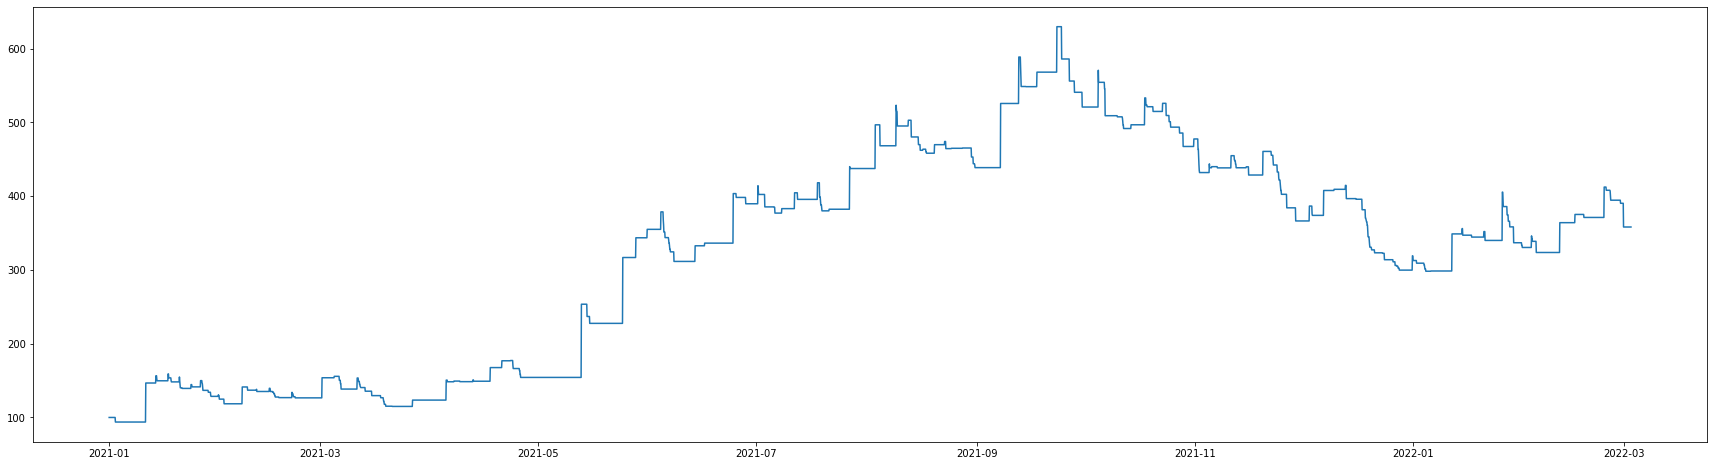

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 8.09%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 26.47%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 26.47%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count      272.000000
mean         0.713342
std          7.463833
min         -8.243055
25%         -2.190524
50%         -1.161700
75%          0.224501
max         64.278902


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count      272.000000
mean         0.713342
std          7.463833
min         -8.243055
25%         -2.190524
50%         -1.161700
75%          0.224501
max         64.278902




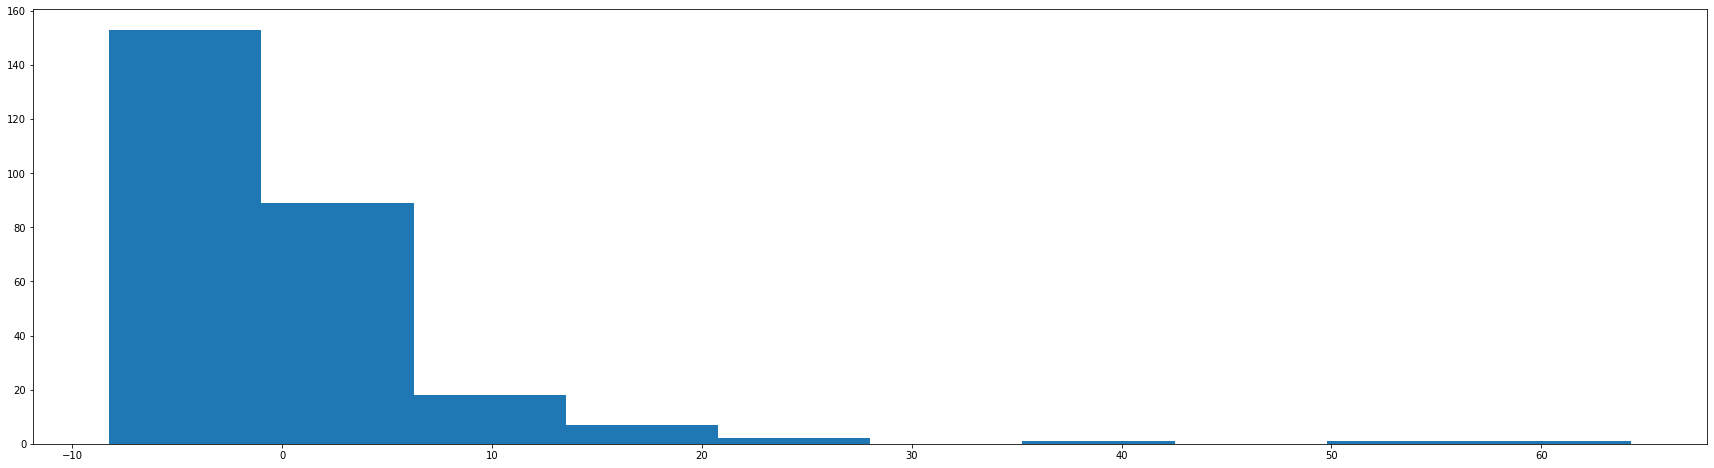

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)